In [1]:
# import torch

# print("Number of GPU: ", torch.cuda.device_count())
# print("GPU Name: ", torch.cuda.get_device_name())


# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# print('Using device:', device)

In [2]:
import tensorflow as tf

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


In [3]:
# split data into train test val using pip split-folder
#%pip install scipy==1.13.1 # pillow==10.3.0 #pip install split-folders matplotlib 




Note: you may need to restart the kernel to use updated packages.


ERROR: Invalid requirement: '#': Expected package name at the start of dependency specifier
    #
    ^


In [ ]:
import splitfolders

# Set the path to your dataset and the output directory
input_dir = "data"  # Replace with your dataset path
output_dir = "output"  # Replace with your desired output path

# Split the dataset
splitfolders.ratio(input_dir, output=output_dir, ratio=(0.8, 0.1, 0.1), seed=42, group_prefix=None)


In [5]:
import os
import time
import random
import numpy as np
import shutil
%matplotlib inline
import matplotlib.image as mping
import matplotlib.pyplot as plt

# Import TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam, Adagrad, Adamax
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import CategoricalAccuracy


In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Set the directory paths
train_dir = "output/train"
test_dir = "output/test"
val_dir = "output/val"

# Rescale the images
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

# Flow from directory for training set
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True,  # Corrected spelling
    color_mode="rgb"
)

# Flow from directory for validation set
validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True,  # Corrected spelling
    color_mode="rgb"
)

# Flow from directory for test set
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True,  # Corrected spelling
    color_mode="rgb"
)


Found 3208 images belonging to 5 classes.
Found 401 images belonging to 5 classes.
Found 401 images belonging to 5 classes.


In [8]:
# callbacks to avoid overfit

class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy') > 0.98:
            print("\nReached 98% accuracy so cancelling training!")
            self.model.stop_training = True
callbacks=myCallback()

In [9]:
# vgg16 model

model = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the VGG16 layers

for layer in model.layers:
    layer.trainable = False


# Add new layers

x = model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(5, activation='softmax')(x)

# Create the final model

model_final = Model(inputs=model.input, outputs=predictions)

In [10]:
# summary  model 

model_final.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [11]:
from tensorflow.keras.optimizers import Adam

model_final.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])



In [12]:
#%pip install scipy


Note: you may need to restart the kernel to use updated packages.


In [13]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Define your callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True),
    ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss', mode='min')
]

# Train the model
history = model_final.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // 32,  # Adjust batch size as needed
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // 32,
    epochs=50,  # Adjust number of epochs as needed
    callbacks=callbacks
)


Epoch 1/50
100/100 [==============================] - 142s 1s/step - loss: 0.6952 - accuracy: 0.7500 - val_loss: 0.2161 - val_accuracy: 0.9375
Epoch 2/50
100/100 [==============================] - 12s 118ms/step - loss: 0.1374 - accuracy: 0.9701 - val_loss: 0.0899 - val_accuracy: 0.9870
Epoch 3/50
100/100 [==============================] - 12s 120ms/step - loss: 0.0648 - accuracy: 0.9880 - val_loss: 0.0614 - val_accuracy: 0.9896
Epoch 4/50
100/100 [==============================] - 12s 120ms/step - loss: 0.0370 - accuracy: 0.9969 - val_loss: 0.0485 - val_accuracy: 0.9896
Epoch 5/50
100/100 [==============================] - 12s 121ms/step - loss: 0.0248 - accuracy: 0.9975 - val_loss: 0.0381 - val_accuracy: 0.9922
Epoch 6/50
100/100 [==============================] - 12s 124ms/step - loss: 0.0146 - accuracy: 1.0000 - val_loss: 0.0319 - val_accuracy: 0.9922
Epoch 7/50
100/100 [==============================] - 18s 181ms/step - loss: 0.0113 - accuracy: 0.9997 - val_loss: 0.0259 - val_accu

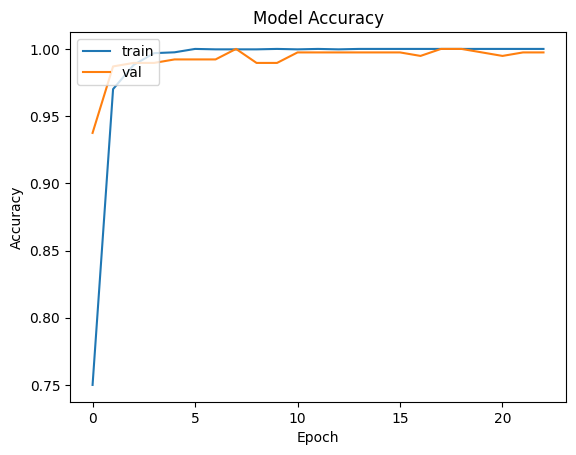

In [14]:
# plot training accuracy

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

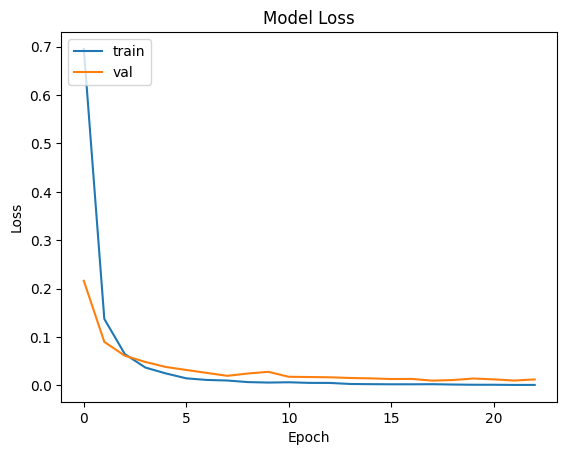

In [15]:
# plot training loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [16]:
# evaluate model

test_loss, test_acc = model_final.evaluate_generator(test_generator, steps=test_generator.samples // 32)
print('Test accuracy:', test_acc)



C:\Users\Office\AppData\Local\Temp\ipykernel_288\2590076306.py:3: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  test_loss, test_acc = model_final.evaluate_generator(test_generator, steps=test_generator.samples // 32)


Test accuracy: 1.0


In [19]:
# # save model

model_final.save('model_final_adam.h5')


In [29]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.image as mpimg

# Load the trained model
model_final = tf.keras.models.load_model('best_model.h5')

# Define the test directory
test_dir = 'data\Krishna'

# Define class mapping based on your provided classes
class_mapping = {
    0: 'Amrita',
    1: 'Krishna',
    2: 'Purple',
    3: 'Rama',
    4: 'Sweet'
}

# Predict on test images
test_images = os.listdir(test_dir)

for img_name in test_images:
    img_path = os.path.join(test_dir, img_name)

    # Check if the path is a file and has a valid image extension
    if os.path.isfile(img_path) and img_name.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
        img = mpimg.imread(img_path)
        
        # Resize and preprocess the image
        img_resized = tf.image.resize(img, (224, 224))
        img_array = tf.keras.preprocessing.image.img_to_array(img_resized).copy()  # Create a writable copy
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
        img_array /= 255.0  # Normalize the image
        
        # Make prediction
        prediction = model_final.predict(img_array)
        predicted_class_index = np.argmax(prediction, axis=1)[0]  # Get the predicted class index
        
        # Map the predicted class index to class name
        predicted_class_name = class_mapping.get(predicted_class_index, "Unknown")
        
        print(f'Image: {img_name}, Prediction: {predicted_class_name}')
    else:
        print(f'Skipping: {img_name} (not a valid image file)')


1/1 [==============================] - 0s 118ms/step
Image: Krishna (1).jpg, Prediction: Krishna
1/1 [==============================] - 0s 17ms/step
Image: Krishna (10).jpg, Prediction: Krishna
1/1 [==============================] - 0s 20ms/step
Image: Krishna (100).jpg, Prediction: Krishna
1/1 [==============================] - 0s 19ms/step
Image: Krishna (101).jpg, Prediction: Krishna
1/1 [==============================] - 0s 18ms/step
Image: Krishna (102).jpg, Prediction: Krishna
1/1 [==============================] - 0s 20ms/step
Image: Krishna (103).jpg, Prediction: Krishna
1/1 [==============================] - 0s 19ms/step
Image: Krishna (104).jpg, Prediction: Krishna
1/1 [==============================] - 0s 18ms/step
Image: Krishna (105).jpg, Prediction: Krishna
1/1 [==============================] - 0s 18ms/step
Image: Krishna (106).jpg, Prediction: Krishna
1/1 [==============================] - 0s 18ms/step
Image: Krishna (107).jpg, Prediction: Krishna
1/1 [=================

KeyboardInterrupt: 